# US Bike Share Activity

## Table of Contents
- [Introduction](#intro)
- [Posing Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Performing Your Own Analysis](#eda_continued)
- [Conclusions](#conclusions)

<a id='intro'></a>
## Introduction


Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. With the latest technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, we will perform an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. We will compare the system usage between three large cities: New York City, Chicago, and Washington, DC. We will also see if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='pose_questions'></a>
## Posing Questions

Before looking at the bike sharing data, rather any data, we should start by asking questions we might want to understand about the bike share data. Consider, for example, if we were working for Motivate. What kinds of information would we want to know about in order to make smarter business decisions? Also, if we are a user of the bike-share service, what factors might influence how we would want to use the service?

Below are the questions that could be asked by someone who is working for Motivate:

1. What are the Stations with high usage rate.
2. What is the average trip duration.
3. Who are the users with high trip duration.
4. What is the Age Group of users with high usage.
5. Stations with high Registered users.

Below are the questions that could be asked by someone who is using the services of Motivate:

1. Start Station Name with high Trip Duration.
2. User Types with high Trip Duration.
3. Popular areas using Station Lat/Long.
4. Average Age Group of users.
5. Season with high users.

<a id='wrangling'></a>
## Data Collection and Wrangling

Now it's time to collect and explore our data. In this project, we will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

If you visit these pages, you will notice that each city has a different way of delivering its data. Chicago updates with new data twice a year, Washington DC is quarterly, and New York City is monthly. Note that some data wrangling of inconsistencies in timestamp format within each city has already been performed and a random 2% sample of the original data is taken to make the exploration more manageable. However, there is still a lot of data for us to investigate.

In [1]:
## import all necessary packages and functions.
import csv # read and write csv files
from datetime import datetime # operations to parse dates
from pprint import pprint # use to print data structures like dictionaries in
                          # a nicer way than the base print function.

In [2]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        ## Use the csv library to set up a DictReader object. ##
        ## see https://docs.python.org/3/library/csv.html           ##
        trip_reader = csv.DictReader(f_in)
        
        ## Use a function on the DictReader object to read the     ##
        ## first trip from the data file and store it in a variable.     ##
        ## see https://docs.python.org/3/library/csv.html#reader-objects ##
        first_trip = trip_reader.__next__()
        
        ## Use the pprint library to print the first trip. ##
        ## see https://docs.python.org/3/library/pprint.html     ##
        pprint(first_trip)
        
    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv',]

# print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

<a id='condensing'></a>
### Condensing the Trip Data

It should also be observable from the above printout that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make things as simple as possible when we get to the actual exploration, we should trim and clean the data. Cleaning the data makes sure that the data formats across the cities are consistent, while trimming focuses only on the parts of the data we are most interested in to make the exploration easier to work with.

Below, we will generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. Use the start time of the trip to obtain these values. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. The [`datetime`](https://docs.python.org/3/library/datetime.html) package will be very useful here to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, we will convert the Washington labels to match the other two.

In [3]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    
    Remember that Washington is in terms of milliseconds while Chicago and NYC
    are in terms of seconds. 
    
    HINT: The csv module reads in all of the data as strings, including numeric
    values. You will need a function to convert the strings into an appropriate
    numeric type when making your transformations.
    see https://docs.python.org/3/library/functions.html
    """
    
    if city == 'Washington':
        # As Washington has the time duration in milliseconds
        # convert them to Minutes by dividing with 60,000
        #print(type(datum))
        #print(datum)
        #print(datum['Duration (ms)'])
        duration = (float(datum['Duration (ms)'])/60000)
    elif city == 'Chicago' or city == 'NYC':
        # As Chicago and NYC has the time in seconds convert
        # them to minutes by dividing with 60
        #print(datum['tripduration'])
        duration = (float(datum['tripduration'])/60)
    else:
        print('Invalid City')
    
    return duration


# Some tests to check that the code works.
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [4]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    
    Remember that NYC includes seconds, while Washington and Chicago do not.
    
    HINT: You should use the datetime module to parse the original date
    strings into a format that is useful for extracting the desired information.
    see https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
    """
    
    # strptime(...) is String Parse Time
    # strftime(...) is String Format Time
    
    # Converted 'month' and 'hour' to Integers to remove leading Zero's.
    
    if city == 'Washington':
        # Washington has 'Start date' as '3/31/2016 22:57'
        # and 'End date' as '3/31/2016 23:04'
        #print(datum['Start date'])
        month = int(datetime.strptime(datum['Start date'],"%m/%d/%Y %H:%M").strftime('%m'))
        hour = int(datetime.strptime(datum['Start date'],"%m/%d/%Y %H:%M").strftime('%H'))
        day_of_week = datetime.strptime(datum['Start date'],"%m/%d/%Y %H:%M").strftime('%A')
    elif city == 'Chicago':
        # Chicago has 'starttime' as '3/31/2016 23:30')
        # and 'stoptime' as '3/31/2016 23:46'
        #print(datum['starttime'])
        month = int(datetime.strptime(datum['starttime'],"%m/%d/%Y %H:%M").strftime('%m'))
        hour = int(datetime.strptime(datum['starttime'],"%m/%d/%Y %H:%M").strftime('%H'))
        day_of_week = datetime.strptime(datum['starttime'],"%m/%d/%Y %H:%M").strftime('%A')
    elif city == 'NYC':
        # NYC has 'starttime' as '1/1/2016 00:09:55')
        # and 'stoptime' as '1/1/2016 00:23:54'
        #print(datum['starttime'])
        month = int(datetime.strptime(datum['starttime'],"%m/%d/%Y %H:%M:%S").strftime('%m'))
        hour = int(datetime.strptime(datum['starttime'],"%m/%d/%Y %H:%M:%S").strftime('%H'))
        day_of_week = datetime.strptime(datum['starttime'],"%m/%d/%Y %H:%M:%S").strftime('%A')
    else:
        print('Invalid City')
    
    return (month, hour, day_of_week)


# Some tests to check that the code works.
tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    assert time_of_trip(example_trips[city], city) == tests[city]

In [5]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    
    Remember that Washington has different category names compared to Chicago
    and NYC. 
    """
    
    # As Washington has different category names change them
    # to reflect the categories in NYC and Chicago.
    if city == 'Washington':
        if datum['Member Type'] == 'Registered':
            datum['Member Type'] = 'Subscriber'
        elif datum['Member Type'] == 'Casual':
            datum['Member Type'] = 'Customer'
        else:
            print("Invalid Member Type for Washington")
        
        user_type = datum['Member Type']
    elif city == 'Chicago' or city == 'NYC':
        user_type = datum['usertype']
    else:
        Print("Invalid City")
    
    return user_type


# Some tests to check that the code works.
tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]

Now, we will use the helper functions written above to create a condensed data file for each city consisting only of the data fields indicated above.

In [6]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    
    HINT: See the cell below to see how the arguments are structured!
    """
    
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        ## Set up csv DictReader object ##
        trip_reader = csv.DictReader(f_in)

        # collect data from and process each row
        for row in trip_reader:
            # set up a dictionary to hold the values for the cleaned and trimmed
            # data point
            new_point = {}
            #print(type(row))
            ## Use the helper functions to get the cleaned data from  ##
            ## the original data dictionaries.                              ##
            ## Note that the keys for the new_point dictionary should match ##
            ## the column names set in the DictWriter object above.         ##
            new_point['duration'] = duration_in_mins(row, city)
            new_point['month'], new_point['hour'], new_point['day_of_week'] = time_of_trip(row, city)
            new_point['user_type'] = type_of_user(row, city)

            ## Write the processed information to the output file.     ##
            ## see https://docs.python.org/3/library/csv.html#writer-objects ##
            trip_writer.writerow(new_point)
            
            

In [7]:
# Generate summary files for each of the cities
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])


<a id='eda'></a>
## Exploratory Data Analysis

Now that we have the data collected and wrangled, we are ready to start exploring the data. In this section we will write some code to compute descriptive statistics from the data. We will also be introduced to the `matplotlib` library to create some basic histograms of the data.

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts. The first cell below contains a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers.

We will try to answer some of the below questions:

Which city has the highest number of trips? Which city has the highest proportion of trips made by subscribers? Which city has the highest proportion of trips made by short-term customers?

1. Which city has the highest number of trips? => NYC
2. Which city has the highest proportion of trips made by subscribers? => NYC
3. Which city has the highest proportion of trips made by short-term customers? => Chicago

In [8]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # Initialize the variables
        n_subscribers = 0
        n_customers = 0
        
        # Count the users based on their type - Subscriber and Customer
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        
        # compute total number of rides
        n_total = n_subscribers + n_customers
        
        # return tallies as a tuple
        return(n_subscribers, n_customers, n_total)

In [9]:
# Get Summary files of the three cities
data_file_Washington = './data/Washington-2016-Summary.csv'
data_file_Chicago = './data/Chicago-2016-Summary.csv'
data_file_NYC = './data/NYC-2016-Summary.csv'

In [10]:
# Create a Dict to store the user count for each city based on the user type
trips_data = {'Washington': {'Subscribers':0, 'Customers':0, 'Total':0},
             'Chicago': {'Subscribers':0, 'Customers':0, 'Total':0},
             'NYC': {'Subscribers':0, 'Customers':0, 'Total':0}}

# Populate the Dict using the data from each of the three csv files.
trips_data['Washington'] = dict(zip(trips_data['Washington'].keys(), number_of_trips(data_file_Washington)))
trips_data['Chicago'] = dict(zip(trips_data['Chicago'].keys(), number_of_trips(data_file_Chicago)))
trips_data['NYC'] = dict(zip(trips_data['NYC'].keys(), number_of_trips(data_file_NYC)))

# Dict to map each of the cities
cities_dict = {1:'Washington' , 2:'Chicago' , 3:'NYC' }
print(cities_dict)

# Store the total trips detail for each city
total_trips_dict = {1:trips_data['Washington']['Total'],
                    2:trips_data['Chicago']['Total'],
                    3:trips_data['NYC']['Total']}

# Find the city with highest number of trips
city_high_trips = max(total_trips_dict, key=total_trips_dict.get)
print("\nWhich city has the highest number of trips?" + " => " + cities_dict[city_high_trips])
print(total_trips_dict)


# Find the proportion of trips made by Subscribers
subs_prop_dict = {1: trips_data['Washington']['Subscribers']/trips_data['Washington']['Total'],
                  2: trips_data['Chicago']['Subscribers']/trips_data['Chicago']['Total'],
                  3: trips_data['NYC']['Subscribers']/trips_data['NYC']['Total']}

# Find the city with highest proportion of trips by Subscribers
city_high_prob_subs = max(subs_prop_dict, key=subs_prop_dict.get)
print("\nWhich city has the highest proportion of trips made by subscribers?" + " => " + cities_dict[city_high_prob_subs])
print(subs_prop_dict)


# Find the proportion of trips made by Customers
cust_prop_dict = {1: trips_data['Washington']['Customers']/trips_data['Washington']['Total'], 
                  2: trips_data['Chicago']['Customers']/trips_data['Chicago']['Total'], 
                  3: trips_data['NYC']['Customers']/trips_data['NYC']['Total']}

# Find the city with highest proportion of trips by Customers
city_high_prob_cust = max(cust_prop_dict, key=cust_prop_dict.get)
print("\nWhich city has the highest proportion of trips made by short-term customers?" + " => " + cities_dict[city_high_prob_cust])
print(cust_prop_dict)

{1: 'Washington', 2: 'Chicago', 3: 'NYC'}

Which city has the highest number of trips? => NYC
{1: 66326, 2: 72131, 3: 276798}

Which city has the highest proportion of trips made by subscribers? => NYC
{1: 0.7802822422579381, 2: 0.7622520136973008, 3: 0.8883590199351151}

Which city has the highest proportion of trips made by short-term customers? => Chicago
{1: 0.21971775774206193, 2: 0.23774798630269925, 3: 0.11164098006488486}


Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. We will now try to answer few questions like - What is the average trip length for each city? What proportion of rides made in each city are longer than 30 minutes?

What is the average trip length for each city?

1. Average Trip Length of Washington = 18 Minutes
2. Average Trip Length of Chicago = 16 Minutes
3. Average Trip Length of NYC = 15 Minutes

What proportion of rides made in each city are longer than 30 minutes?

1. Percentage Trips Longer Than 30 Minutes in Washington = 10.84%
2. Percentage Trips Longer Than 30 Minutes in Chicago = 8.33%
3. Percentage Trips Longer Than 30 Minutes in NYC = 7.3%

In [11]:
# Get the total trips for each city
total_trips_washington = total_trips_dict[1]
total_trips_chicago = total_trips_dict[2]
total_trips_nyc = total_trips_dict[3]

In [12]:
def avg_trip_length(filename, city):
    '''
        Get the average trip length based on the city filename
    '''
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # Initialize the variables
        total_trip_length = 0
        
        # Get the total trip length
        for row in reader:
            total_trip_length = total_trip_length + float(row['duration'])
        
        # Get total number of rides for each city
        if city == 'Washington':
            total_trips = total_trips_washington
        elif city == 'Chicago':
            total_trips = total_trips_chicago
        else:
            total_trips = total_trips_nyc
        
        # return average trip length in minutes(rounded)
        return(int(total_trip_length/total_trips))
    
# Get Average Trip Length for each City
avg_trip_length_washington = avg_trip_length(data_file_Washington, 'Washington')
avg_trip_length_chicago = avg_trip_length(data_file_Chicago, 'Chicago')
avg_trip_length_nyc = avg_trip_length(data_file_NYC, 'NYC')

# Print Average Trip Length for each City
print("\n*** Average Trip Length for each City ***\n")
print("Average Trip Length of Washington" + " = " + str(avg_trip_length_washington) + " Minutes")
print("Average Trip Length of Chicago" + " = " + str(avg_trip_length_chicago) + " Minutes")
print("Average Trip Length of NYC" + " = " + str(avg_trip_length_nyc) + " Minutes")


*** Average Trip Length for each City ***

Average Trip Length of Washington = 18 Minutes
Average Trip Length of Chicago = 16 Minutes
Average Trip Length of NYC = 15 Minutes


In [13]:
def longer_trip_percent(filename, city):
    '''
        Get percent of trips that are longer than 30 minutes
    '''
    TRIP_DURATION = 30.0
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # Initialize the variables
        longer_trip_count = 0
        
        # Get the no of trips longer than 30 Minutes
        for row in reader:
            if float(row['duration']) > TRIP_DURATION:
                longer_trip_count += 1
        
        # Get total number of rides for each city
        if city == 'Washington':
            total_trips = total_trips_washington
        elif city == 'Chicago':
            total_trips = total_trips_chicago
        else:
            total_trips = total_trips_nyc
            
        # return % of trips that are longer than 30 minutes(rounded to 2 decimal places)
        return((round(longer_trip_count/total_trips, 4) * 100))

# Get percentage of trips that are longer than 30 minutes for each city
long_trip_per_washington = longer_trip_percent(data_file_Washington, 'Washington')
long_trip_per_chicago = longer_trip_percent(data_file_Chicago, 'Chicago')
long_trip_per_nyc = longer_trip_percent(data_file_NYC, 'NYC')

# Print percentage of trips that are longer than 30 minutes for each city
print("\n*** Percentage of trips that are longer than 30 minutes ***\n")
print("Percentage Trips Longer Than 30 Minutes in Washington" + " = " + str(long_trip_per_washington) + "%")
print("Percentage Trips Longer Than 30 Minutes in Chicago" + " = " + str(long_trip_per_chicago) + "%")
print("Percentage Trips Longer Than 30 Minutes in NYC" + " = " + str(long_trip_per_nyc) + "%")


*** Percentage of trips that are longer than 30 minutes ***

Percentage Trips Longer Than 30 Minutes in Washington = 10.84%
Percentage Trips Longer Than 30 Minutes in Chicago = 8.33%
Percentage Trips Longer Than 30 Minutes in NYC = 7.3%


Now, we will dig deeper into the question of trip duration based on ridership. We will try to see which type of user takes longer rides on average: Subscribers or Customers?

1. For Washington => Subscribers Avg Duration = 12.53; Customers Avg Duration = 41.68
2. For Chicago => Subscribers Avg Duration = 12.07; Customers Avg Duration = 30.98
3. For NYC => Subscribers Avg Duration = 13.68; Customers Avg Duration = 32.78


1. In Washington Customers take longer rides than Subscribers
2. In Chicago Customers take longer rides than Subscribers
3. In NYC Customers take longer rides than Subscribers

In [14]:
def rides_user_type(filename, city):
    '''
        Get the rides based on user type - Subscribers and Customers
    '''
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize the variables
        trip_length_subscribers = 0
        trip_count_subscribers = 0
        
        trip_length_customers = 0
        trip_count_customers = 0
        
        # Get the trip length and trip counts for Subscribers and
        # Customers in each city.
        for row in reader:
            if city == 'Washington':
                if row['user_type'] == 'Subscriber':
                    trip_length_subscribers += float(row['duration'])
                    trip_count_subscribers += 1
                else:
                    trip_length_customers += float(row['duration'])
                    trip_count_customers += 1
            elif city == 'Chicago':
                if row['user_type'] == 'Subscriber':
                    trip_length_subscribers += float(row['duration'])
                    trip_count_subscribers += 1
                else:
                    trip_length_customers += float(row['duration'])
                    trip_count_customers += 1
            else:
                if row['user_type'] == 'Subscriber':
                    trip_length_subscribers += float(row['duration'])
                    trip_count_subscribers += 1
                else:
                    trip_length_customers += float(row['duration'])
                    trip_count_customers += 1
              
        # return average trip duration for Subscribers and Customers
        avg_trip_len_subscriber = round((trip_length_subscribers/trip_count_subscribers), 2)
        avg_trip_len_customer = round((trip_length_customers/trip_count_customers), 2)
        return(avg_trip_len_subscriber, avg_trip_len_customer)

# Get the average trip length for Subscribers and Customers in each city.     
avg_trip_len_subs_washington, avg_trip_len_cust_washington = rides_user_type(data_file_Washington, 'Washington')
avg_trip_len_subs_chicago, avg_trip_len_cust_chicago = rides_user_type(data_file_Chicago, 'Chicago')
avg_trip_len_subs_nyc, avg_trip_len_cust_nyc = rides_user_type(data_file_NYC, 'NYC')

# Print the average trip length for Subscribers and Customers in each city.
print("\n*** Average trip length for Subscribers or Customers? ***\n")
print("For Washington" + " => " + "Subscribers Avg Duration = " + str(avg_trip_len_subs_washington) + "; Customers Avg Duration = " + str (avg_trip_len_cust_washington))
print("For Chicago" + " => " + "Subscribers Avg Duration = " + str(avg_trip_len_subs_chicago) + "; Customers Avg Duration = " + str (avg_trip_len_cust_chicago))
print("For NYC" + " => " + "Subscribers Avg Duration = " + str(avg_trip_len_subs_nyc) + "; Customers Avg Duration = " + str (avg_trip_len_cust_nyc))

print("\n*** Who take longer rides - Subscribers or Customers? ***\n")

# Print the user type - Subscribers or Customers who take longer rides each city.
if (avg_trip_len_subs_washington > avg_trip_len_cust_washington):
    print ("In Washington Subscribers take longer rides than Customers")
else:
    print ("In Washington Customers take longer rides than Subscribers")
    
if (avg_trip_len_subs_chicago > avg_trip_len_cust_chicago):
    print ("In Chicago Subscribers take longer rides than Customers")
else:
    print ("In Chicago Customers take longer rides than Subscribers")
    
if (avg_trip_len_subs_nyc > avg_trip_len_cust_nyc):
    print ("In NYC Subscribers take longer rides than Customers")
else:
    print ("In NYC Customers take longer rides than Subscribers")


*** Average trip length for Subscribers or Customers? ***

For Washington => Subscribers Avg Duration = 12.53; Customers Avg Duration = 41.68
For Chicago => Subscribers Avg Duration = 12.07; Customers Avg Duration = 30.98
For NYC => Subscribers Avg Duration = 13.68; Customers Avg Duration = 32.78

*** Who take longer rides - Subscribers or Customers? ***

In Washington Customers take longer rides than Subscribers
In Chicago Customers take longer rides than Subscribers
In NYC Customers take longer rides than Subscribers


<a id='visualizations'></a>
### Visualizations

The last set of values that we computed should have pulled up an interesting result. While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting for us to look at how the trip times are distributed. In order to do this, a new library will be introduced here, `matplotlib`.

In [15]:
# load library
import matplotlib.pyplot as plt

# this is a 'magic word' that allows for plots to be displayed
# inline with the notebook. If you want to know more, see:
# http://ipython.readthedocs.io/en/stable/interactive/magics.html
%matplotlib inline

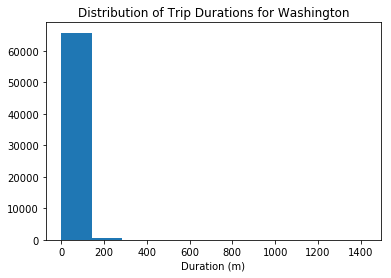

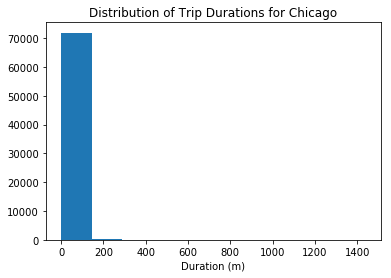

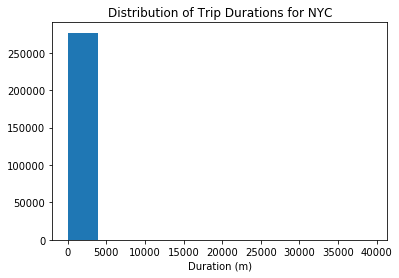

In [16]:
## Collect all of the trip times and use pyplot to generate a histogram of trip times.
def trip_times(filename, city):
    '''
        Get the trip times for each of the cities.
    '''
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize the variables
        trip_times_washington = []
        trip_times_chicago = []
        trip_times_nyc = []
        
        # Create the trip time list for each city
        for row in reader:
            if city == 'Washington':
                trip_times_washington.append(float(row['duration']))
            elif city == 'Chicago':
                trip_times_chicago.append(float(row['duration']))
            else:
                trip_times_nyc.append(float(row['duration']))
              
        # return the trip time list for each city
        if city == 'Washington':
            return trip_times_washington
        elif city == 'Chicago':
            return trip_times_chicago
        else:
            return trip_times_nyc

# Get the trip time list for each city
trip_times_washington = trip_times(data_file_Washington, 'Washington')
trip_times_chicago = trip_times(data_file_Chicago, 'Chicago')
trip_times_nyc = trip_times(data_file_NYC, 'NYC')

# Plot the histogram of trip durations for each city
plt.hist(trip_times_washington)
plt.title('Distribution of Trip Durations for Washington')
plt.xlabel('Duration (m)')
plt.show()

plt.hist(trip_times_chicago)
plt.title('Distribution of Trip Durations for Chicago')
plt.xlabel('Duration (m)')
plt.show()

plt.hist(trip_times_nyc)
plt.title('Distribution of Trip Durations for NYC')
plt.xlabel('Duration (m)')
plt.show()

The above code shows histograms that's completely unexpected. The plot consists of one extremely tall bar on the left and a whole lot of empty space in the center and right. Take a look at the duration values on the x-axis. This suggests that there are some highly infrequent outliers in the data. Instead of reprocessing the data, we will use additional parameters with the `.hist()` function to limit the range of data that is plotted. Documentation for the function can be found [[here]](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib.pyplot.hist).

We will now use the parameters of the `.hist()` function to plot the distribution of trip times for the Subscribers. We will also do the same thing for only the Customers. We will also Add limits to the plots so that only trips of duration less than 75 minutes are plotted. As a bonus, we will set the plots up so that bars are in five-minute wide intervals. We will try to answer few questions like - For each group, where is the peak of each distribution? How would you describe the shape of each distribution?


1. For each group, where is the peak of each distribution? - The peak is approximately at the Average Trip Duration (Mean).
2. How would you describe the shape of each distribution? - Most of the distributons are skewed to the right.

In [18]:
def trip_times_subs_cust(filename, city):
    '''
        Get the trip times for each of the cities.
    '''
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize the variables
        trip_times_subs_washington = []
        trip_times_cust_washington = []
        trip_times_subs_chicago = []
        trip_times_cust_chicago = []
        trip_times_subs_nyc = []
        trip_times_cust_nyc = []
        
        # Get the trip times for Subscribers and Customers for each city
        for row in reader:
            if city == 'Washington':
                if row['user_type'] == 'Subscriber':
                    trip_times_subs_washington.append(float(row['duration']))
                else:
                    trip_times_cust_washington.append(float(row['duration']))
            elif city == 'Chicago':
                if row['user_type'] == 'Subscriber':
                    trip_times_subs_chicago.append(float(row['duration']))
                else:
                    trip_times_cust_chicago.append(float(row['duration']))
            else:
                if row['user_type'] == 'Subscriber':
                    trip_times_subs_nyc.append(float(row['duration']))
                else:
                    trip_times_cust_nyc.append(float(row['duration']))
              
        # return trip duration of Subscribers and Customers for each city
        if city == 'Washington':
            return (trip_times_subs_washington, trip_times_cust_washington)
        elif city == 'Chicago':
            return (trip_times_subs_chicago, trip_times_cust_chicago)
        else:
            return (trip_times_subs_nyc, trip_times_cust_nyc)

# Get trip duration of Subscribers and Customers for each city
trip_times_subs_washington, trip_times_cust_washington = trip_times_subs_cust(data_file_Washington, 'Washington')
trip_times_subs_chicago, trip_times_cust_chicago = trip_times_subs_cust(data_file_Chicago, 'Chicago')
trip_times_subs_nyc, trip_times_cust_nyc = trip_times_subs_cust(data_file_NYC, 'NYC')

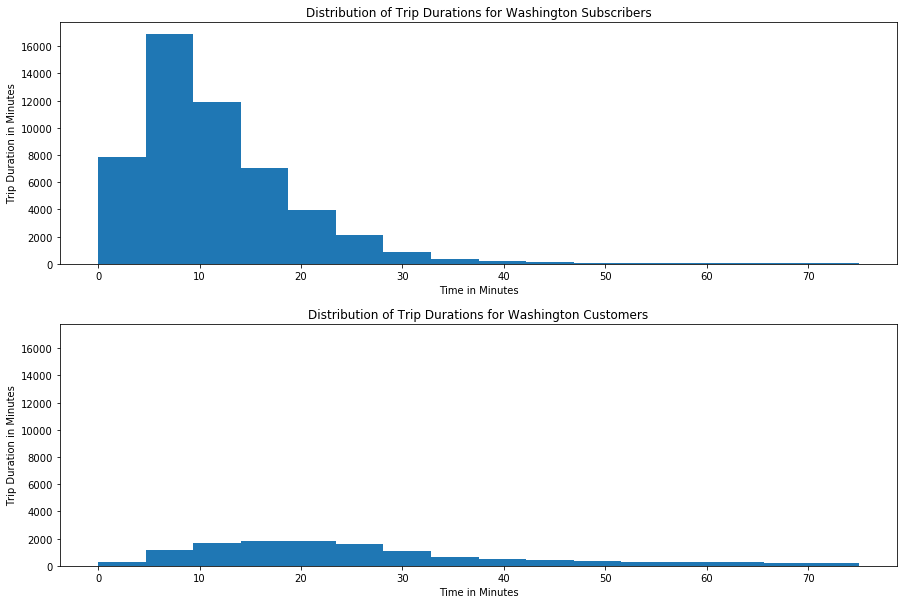

In [19]:
# Plot the histogram of trip durations for Washington users
f, (plt1, plt2) = plt.subplots(2, sharey=True)
plt1.hist(trip_times_subs_washington, range = (0, 75), bins = 16)
plt1.set_title('Distribution of Trip Durations for Washington Subscribers')
plt1.set_xlabel('Time in Minutes')
plt1.set_ylabel("Trip Duration in Minutes")

plt2.hist(trip_times_cust_washington, range = (0, 75), bins = 16)
plt2.set_title('Distribution of Trip Durations for Washington Customers')
plt2.set_xlabel('Time in Minutes')
plt2.set_ylabel("Trip Duration in Minutes")

f.subplots_adjust(hspace=0.25)
f.set_figheight(10)
f.set_figwidth(15)
plt.show()

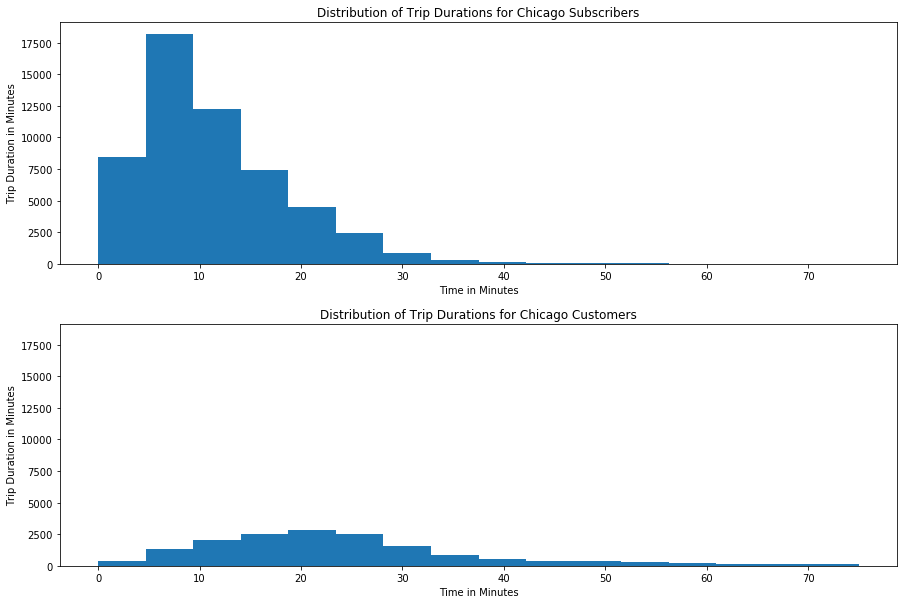

In [20]:
# Plot the histogram of trip durations for Chicago users
f, (plt1, plt2) = plt.subplots(2, sharey=True)
plt1.hist(trip_times_subs_chicago, range = (0, 75), bins = 16)
plt1.set_title('Distribution of Trip Durations for Chicago Subscribers')
plt1.set_xlabel('Time in Minutes')
plt1.set_ylabel("Trip Duration in Minutes")

plt2.hist(trip_times_cust_chicago, range = (0, 75), bins = 16)
plt2.set_title('Distribution of Trip Durations for Chicago Customers')
plt2.set_xlabel('Time in Minutes')
plt2.set_ylabel("Trip Duration in Minutes")

f.subplots_adjust(hspace=0.25)
f.set_figheight(10)
f.set_figwidth(15)
plt.show()

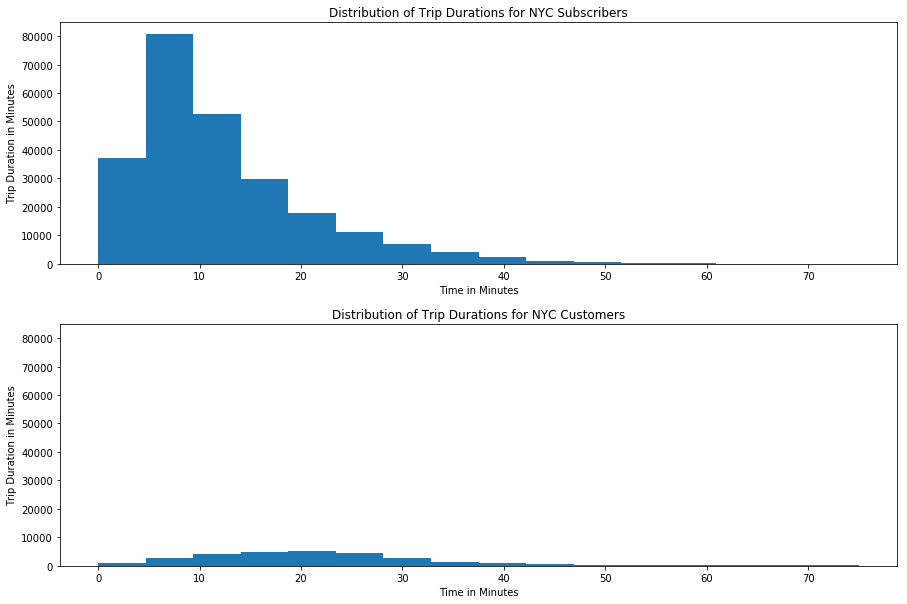

In [21]:
# Plot the histogram of trip durations for NYC users
f, (plt1, plt2) = plt.subplots(2, sharey=True)
plt1.hist(trip_times_subs_nyc, range = (0, 75), bins = 16)
plt1.set_title('Distribution of Trip Durations for NYC Subscribers')
plt1.set_xlabel('Time in Minutes')
plt1.set_ylabel("Trip Duration in Minutes")

plt2.hist(trip_times_cust_nyc, range = (0, 75), bins = 16)
plt2.set_title('Distribution of Trip Durations for NYC Customers')
plt2.set_xlabel('Time in Minutes')
plt2.set_ylabel("Trip Duration in Minutes")

f.subplots_adjust(hspace=0.25)
f.set_figheight(10)
f.set_figwidth(15)
plt.show()

<a id='eda_continued'></a>
## More Analysis

We will try to analyze few more areas here:

1. How does ridership differ by month for Washington? - Ridership tends to increase every month until the mid year and then it starts to decrease
2. Which month has the highest ridership for Washington? - July
3. Does the ratio of Subscriber trips to Customer trips change depending on the month or season? - Yes. It's highest in the starting months.
4. Is the pattern of ridership different on the weekends versus weekdays? - Yes. On weekdays the average trip duration is high.
5. On what days are Subscribers most likely to use the system? What about Customers? - Subscribers are using the system mostly on weekdays and Customers are using the system mostly on weekends.

Ridership by Month for Washington => {1: 31140.223600000107, 2: 36565.14208333328, 3: 110075.18485000047, 4: 109825.68944999986, 5: 116117.24186666649, 6: 153950.80770000006, 7: 168083.57223333383, 8: 134724.9150000009, 9: 131644.45458333314, 10: 125110.32186666655, 11: 89993.60525000017, 12: 48510.61320000002}


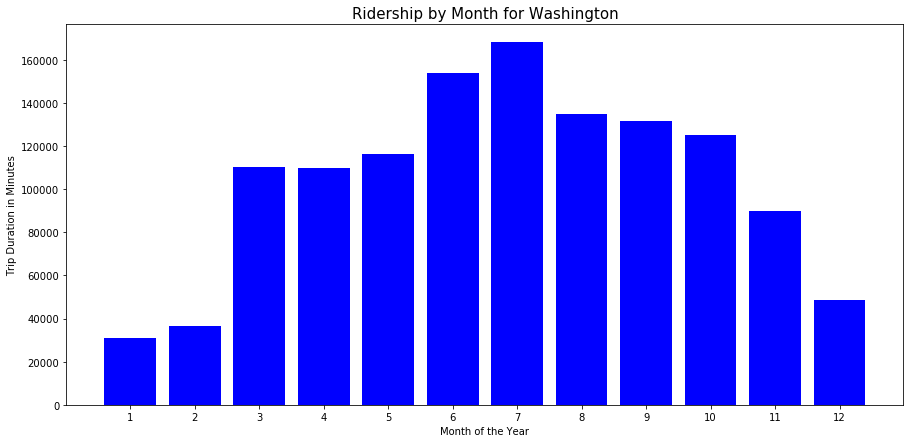

In [22]:
# How does ridership differ by month or season? Which month / season has the highest ridership?
def duration_by_month(filename):
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # Initialize the dict to hold trip duration by month
        dur_month = {1:0, 2:0, 3:0, 4: 0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}
        
        # Get the trip duration by month
        for row in reader:
            dur_month[int(row['month'])] += float(row['duration'])
                
        return (dur_month)


dur_by_month_Washington = duration_by_month(data_file_Washington)
print("Ridership by Month for Washington => "+ str(dur_by_month_Washington))

no_of_months = range(12)
plt.figure(figsize=(15,7))
plt.bar(no_of_months, dur_by_month_Washington.values(), color='b', align='center')
plt.xticks(no_of_months, dur_by_month_Washington.keys())
plt.xlabel("Month of the Year")
plt.ylabel("Trip Duration in Minutes")
plt.title("Ridership by Month for Washington", fontsize=15)
plt.show()

Subscriber Trips by Month => {1: 2212, 2: 2571, 3: 4383, 4: 4410, 5: 4520, 6: 5613, 7: 5155, 8: 5392, 9: 5204, 10: 5232, 11: 4139, 12: 2922}
Customer Trips by Month => {1: 222, 2: 283, 3: 1188, 4: 1192, 5: 1248, 6: 1707, 7: 2186, 8: 1806, 9: 1674, 10: 1560, 11: 1075, 12: 432}


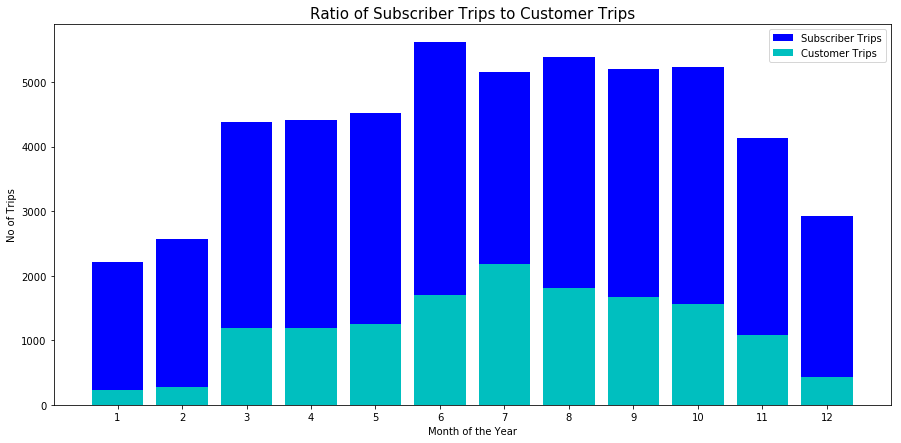

Ratio of Subscriber to Customer Trips => {1: 9.96, 2: 9.08, 3: 3.69, 4: 3.7, 5: 3.62, 6: 3.29, 7: 2.36, 8: 2.99, 9: 3.11, 10: 3.35, 11: 3.85, 12: 6.76}


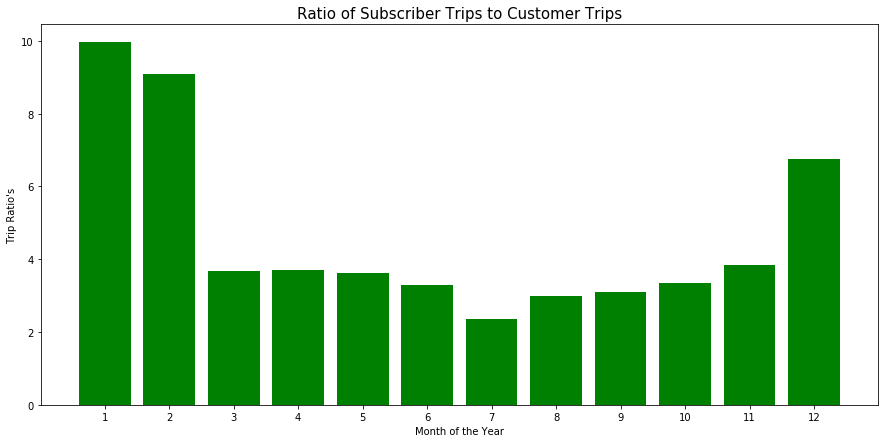

In [26]:
# Does the ratio of Subscriber trips to Customer trips change depending on the month or season?
def trips_by_month(filename, user_type):
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # Initialize the dict to hold trips by month
        trips_month = {1:0, 2:0, 3:0, 4: 0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}
        
        # Get the trips for each month for different users
        for row in reader:
            if user_type == 'Subscriber' and row['user_type'] == 'Subscriber':
                trips_month[int(row['month'])] += 1
            elif user_type == 'Customer' and row['user_type'] == 'Customer':
                trips_month[int(row['month'])] += 1
                
        return (trips_month)


trips_month_subs = trips_by_month(data_file_Washington, 'Subscriber')
print("Subscriber Trips by Month => " + str(trips_month_subs))

trips_month_cust = trips_by_month(data_file_Washington, 'Customer')
print("Customer Trips by Month => " + str(trips_month_cust))

no_of_months = range(12)
plt.figure(figsize=(15,7))
plt.bar(no_of_months, trips_month_subs.values(), color='b', align='center')
plt.bar(no_of_months, trips_month_cust.values(), color='c', align='center')
plt.legend(('Subscriber Trips','Customer Trips'))
plt.xticks(no_of_months, trips_month_subs.keys())
plt.xlabel("Month of the Year")
plt.ylabel("No of Trips")
plt.title("Ratio of Subscriber Trips to Customer Trips", fontsize=15)
plt.show()

# Get the Ratio of Subscriber Trips to Customer Trips
ratio_of_trips = {mon: round(trips_month_subs[mon]/trips_month_cust[mon],2) for mon in trips_month_subs}
print("Ratio of Subscriber to Customer Trips => " + str(ratio_of_trips))

no_of_months = range(12)
plt.figure(figsize=(15,7))
plt.bar(no_of_months, ratio_of_trips.values(), color='g', align='center')
plt.xticks(no_of_months, ratio_of_trips.keys())
plt.xlabel('Month of the Year')
plt.ylabel("Trip Ratio's")
plt.title("Ratio of Subscriber Trips to Customer Trips", fontsize=15)
plt.show()

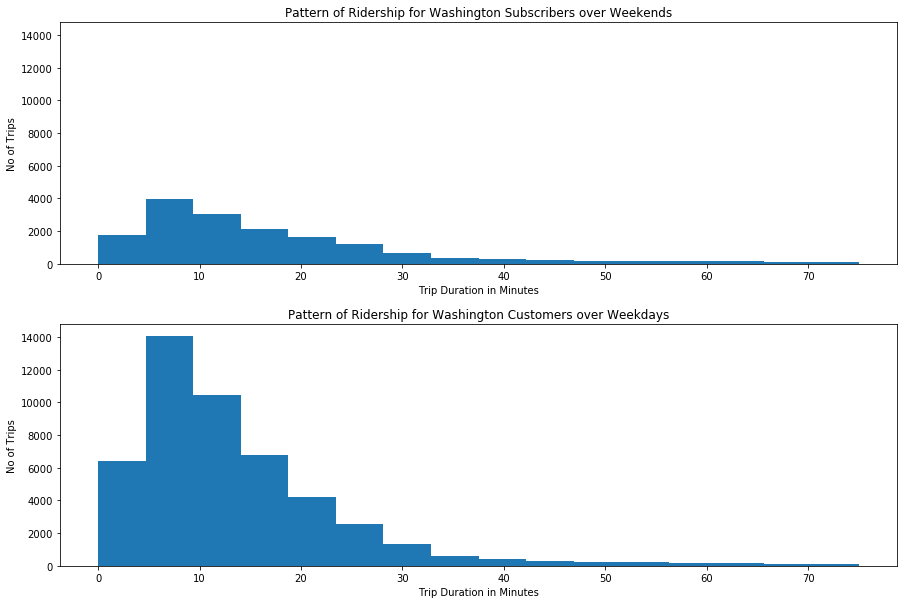

In [27]:
# Is the pattern of ridership different on the weekends versus weekdays?
def trips_by_day_of_week(filename):
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize the variables
        weekend_duration = []
        weekend_no_of_rides = 0
        
        weekday_duration = []
        weekday_no_of_rides = 0
        
        # Get the trip count and duration for weekends and weekdays.
        for row in reader:
            if row['day_of_week'] == 'Saturday' or row['day_of_week'] == 'Sunday':
                weekend_duration.append(float(row['duration']))
                weekend_no_of_rides += 1
            else:
                weekday_duration.append(float(row['duration']))
                weekday_no_of_rides += 1
            
        return (weekend_duration, weekend_no_of_rides, weekday_duration, weekday_no_of_rides)

weekend_duration, weekend_no_of_rides, weekday_duration, weekday_no_of_rides = trips_by_day_of_week(data_file_Washington)

# Plot the histograms
f, (plt1, plt2) = plt.subplots(2, sharey=True)
plt1.hist(weekend_duration, range = (0, 75), bins = 16)
plt1.set_title('Pattern of Ridership for Washington Subscribers over Weekends')
plt1.set_xlabel('Trip Duration in Minutes')
plt1.set_ylabel("No of Trips")

plt2.hist(weekday_duration, range = (0, 75), bins = 16)
plt2.set_title('Pattern of Ridership for Washington Customers over Weekdays')
plt2.set_xlabel('Trip Duration in Minutes')
plt2.set_ylabel("No of Trips")

f.subplots_adjust(hspace=0.25)
f.set_figheight(10)
f.set_figwidth(15)
plt.show()

Subscriber Trips by Day of Week => {1: 7658, 2: 8322, 3: 8520, 4: 8454, 5: 7958, 6: 5589, 7: 5252}
Customer Trips by Day of Week => {1: 1736, 2: 1426, 3: 1583, 4: 1530, 5: 2012, 6: 3311, 7: 2975}


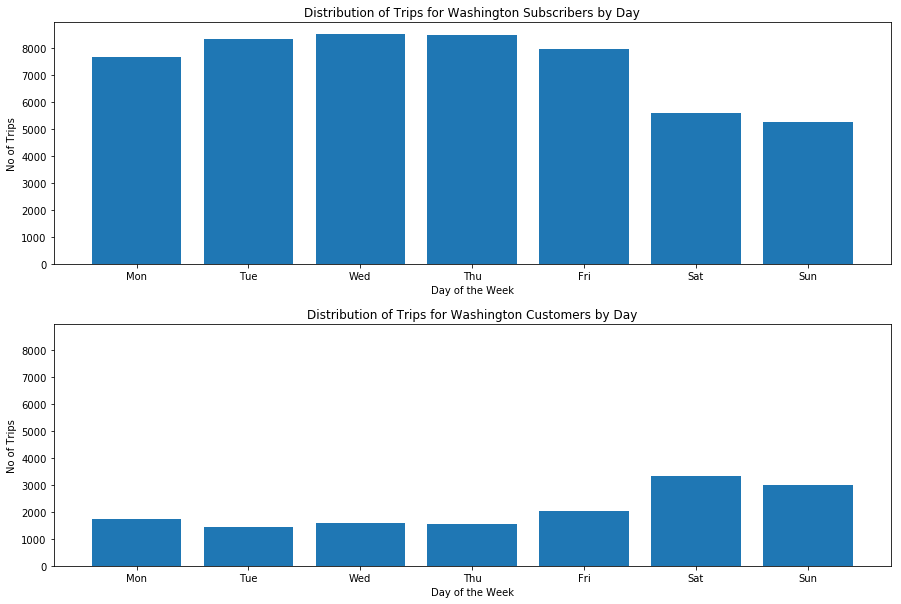

In [32]:
# On what days are Subscribers most likely to use the system? What about Customers?
# Does the average duration of rides change depending on the day of the week?
def trips_by_day(filename, user_type):
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize the variables
        days_of_week = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}
        trips_day_of_week = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}
        
        # Get the trip count for Subscribers and Customers for each day of the week
        for row in reader:
            if user_type == 'Subscriber' and row['user_type'] == 'Subscriber':
                trips_day_of_week[days_of_week[row['day_of_week']]] += 1
            elif user_type == 'Customer' and row['user_type'] == 'Customer':
                trips_day_of_week[days_of_week[row['day_of_week']]] += 1
                
        return (trips_day_of_week)

day_of_weeks_list = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

trips_day_of_week_subs = trips_by_day(data_file_Washington, 'Subscriber')
print("Subscriber Trips by Day of Week => " + str(trips_day_of_week_subs))

trips_day_of_week_cust = trips_by_day(data_file_Washington, 'Customer')
print("Customer Trips by Day of Week => " + str(trips_day_of_week_cust))

# Plot the bar chart for Washington Subscribers
f, (plt1, plt2) = plt.subplots(2, sharey=True)
plt1.bar(list(trips_day_of_week_subs.keys()), trips_day_of_week_subs.values())
plt1.set_xticks(list(trips_day_of_week_subs.keys()))
plt1.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt1.set_xlabel("Day of the Week")
plt1.set_ylabel('No of Trips')
plt1.set_title('Distribution of Trips for Washington Subscribers by Day')

# Plot the bar chart for Washington Customers
plt2.bar(list(trips_day_of_week_cust.keys()), trips_day_of_week_cust.values())
plt2.set_xticks(list(trips_day_of_week_cust.keys()))
plt2.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt2.set_xlabel("Day of the Week")
plt2.set_ylabel('No of Trips')
plt2.set_title('Distribution of Trips for Washington Customers by Day')

f.subplots_adjust(hspace=0.25)
f.set_figheight(10)
f.set_figwidth(15)
plt.show()

<a id='conclusions'></a>
## Conclusions

I hope this notebook is useful and feel free to send in your suggestions and comments. A big thanks to Udacity for the data and other stuff.